<div style="text-align: right"> Mark Hendricks </div>

<left>FINM 36700 - Portfolio Theory and Risk Management</left> 
<br>
<left>Fall 2022</left>

<h2><center> Homework 6 - AQR's Momentum Funds. </center></h2>

<center>Due on Monday, Nov 7</center>

<h3><span style="color:#00008B">Solution - Piyush Kontu</span></h3>

<h3><span style="color:#00008B">Email - pkontu@uchicago.edu</span></h3>

### Case: AQR's Momentum Funds (A) [9-211-025].

## 1. The Momentum Product

#### <i> This section is not graded, and you do not need to submit your answers. But you are expected to consider these issues and be ready to discuss them.</i>

#### 1.1 What is novel about the AQR Momentum product under construction compared to the various momentum investment products already offered?

- The new product is a open-end momentum mutual fund, and thus it will be available to retail investors rather than just those able to invest in hedge-funds. <br><br>
- To satisfy regulatory requirements, this implementation of momentum will be restricted to long-only and to large stocks.<br><br>
- AQR planned to distribute the mutual fund through the financial advisor channel 

#### 1.2 Name three reasons the momentum investment product will not exactly track the momentum index, (i.e. why the strategy will have tracking error.)

- Index would be long-short, whereas AQR's fund would be long-only. <br><br>
- The index was rebalanced monthly and would need enormous amount of trading to replicate. <br><br>
- The index used all listed stocks, whereas AQR's fund would only use stocks with reasonable market capitalization and liquidity.


#### 1.3 When constructing the momentum portfolio, AQR ranks stocks on their returns from month $t − 12$ through $t − 2$. Why don’t they include the $t − 1$ return in this ranking?

- It was common to skip  $t − 1$ as there was evidence of short term price reversal i.e. stocks with high returns last month tend to reverse in the following month.

# Imports

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import kurtosis, skew
from scipy.stats import norm
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader as dr

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=[15, 6]
import matplotlib.cm as cm

# Helper Functions

In [2]:
def performance_summary(return_data):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*12)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(12))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']
    
    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.5)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.5)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

In [3]:
def regression_based_performance(factor,fund_ret,rf,constant = True):
    """ 
        Returns the Regression based performance Stats for given set of returns and factors
        Inputs:
            factor - Dataframe containing monthly returns of the regressors
            fund_ret - Dataframe containing monthly excess returns of the regressand fund
            rf - Monthly risk free rate of return
        Output:
            summary_stats - (Beta of regression, treynor ratio, information ratio, alpha). 
    """
    if constant:
        X = sm.tools.add_constant(factor)
    else:
        X = factor
    y=fund_ret
    model = sm.OLS(y,X,missing='drop').fit()
    
    if constant:
        beta = model.params[1:]
        alpha = round(float(model.params['const']),6) *12

        
    else:
        beta = model.params
    treynor_ratio = ((fund_ret - rf).mean()*12)/beta[0]
    tracking_error = (model.resid.std()*np.sqrt(12))
    if constant:        
        information_ratio = model.params[0]*12/tracking_error
    r_squared = model.rsquared
    if constant:
        return (beta,treynor_ratio,information_ratio,alpha,r_squared,tracking_error,model.resid)
    else:
        return (beta,treynor_ratio,r_squared,tracking_error,model.resid)

In [4]:
def tangency_portfolio_rfr(asset_return,cov_matrix):
    """ 
        Returns the tangency portfolio weights in a (1 x n) vector when a riskless assset is available
        Inputs: 
            asset_return - Excess return over the risk free rate for each asset (n x 1) Vector
            cov_matrix = nxn covariance matrix for the assets
    """
    asset_cov = np.array(cov_matrix)
    inverted_cov= np.linalg.inv(asset_cov)
    one_vector = np.ones(len(cov_matrix.index))
    
    den = (one_vector @ inverted_cov) @ (asset_return)
    num =  inverted_cov @ asset_return
    return (1/den) * num

# Reading Data

In [5]:
ff_factors = pd.read_excel(r'C:\Users\piyus\Documents\Repos\finm-portfolio-2022\data\momentum_data.xlsx',sheet_name = 'factors (excess returns)')
ff_factors = ff_factors.set_index('Date')

In [6]:
size_ports = pd.read_excel(r'C:\Users\piyus\Documents\Repos\finm-portfolio-2022\data\momentum_data.xlsx',sheet_name = 'size_sorts (total returns)')
size_ports = size_ports.set_index('Date')

In [7]:
rf = pd.read_excel(r'C:\Users\piyus\Documents\Repos\finm-portfolio-2022\data\momentum_data.xlsx',sheet_name = 'risk-free rate')
rf = rf.set_index('Date')

In [8]:
mom_deciles = pd.read_excel(r'C:\Users\piyus\Documents\Repos\finm-portfolio-2022\data\momentum_data.xlsx',sheet_name = 'deciles (total returns)')
mom_deciles = mom_deciles.set_index('Date')

In [9]:
momentum = pd.read_excel(r'C:\Users\piyus\Documents\Repos\finm-portfolio-2022\data\momentum_data.xlsx',sheet_name = 'momentum (excess returns)')
momentum = momentum.set_index('Date')

ff_factors['UMD'] = momentum['UMD']

## 2) Investigating Momentum

#### In this section, we empirically investigate some concerns regarding AQR’s new momentum product.

#### On GitHub, find the data file, “momentum data.xlsx”.


- #### The third tab contains the momentum factor as an excess return: $\tilde{r}^{mom}$


- #### The fourth tab contains returns on portfolios corresponding to scored momentum deciles.
    - #### $\tilde{r}^{mom(1)}$ denotes the portfolio of stocks in the lowest momentum decile, the “losers” with the lowest past returns.
    - #### $\tilde{r}^{mom(10)}$ denotes the portfolio of stocks in the highest momentum decile.


- #### The fifth tab gives portfolios sorted by momentum and size.
    - #### $\tilde{r}^{momSU}$ denotes the portfolio of small stocks in the top 3 deciles of momentum scores.
    - #### $\tilde{r}^{momBD}$ denotes the portfolio of big-stocks in the bottom 3 deciles of momentum scores.


#### Note that the Fama-French momentum return, $\tilde{r}^{mom:FF}$, given in the third tab, is constructed by FF as,


#### $$\tilde{r}^{mom:FF} = \frac{1}{2} (\tilde{r}^{momBU} + \tilde{r}^{momSU}) − \frac{1}{2} (\tilde{r}^{momBD} + \tilde{r}^{momSD}) $$

### 2.1.a) Is momentum still profitable?

The excess returns of lucrative trading strategies often disappear once the strategy is well-known. The first widely-cited paper on momentum was published in 1993. Have momentum returns or risk changed since then? The AQR case takes place at the end of 2008. Have momentum returns changed in 2009-2021?


Investigate by filling out the summary statistics below for the full-sample and three sub-samples.

(a) Using the data provided, fill in Table 1 with the appropriate stats for $\tilde{r}^{mom:FF}$

|<caption>Table 1: Momentum performance over time.</caption>|Subsample|mean|vol|Sharpe|Skewness|corr. to $\tilde{r}^m$|corr. to $\tilde{r}^v$|
|------------------------:|------------------------:|-----------------------:|------------------------:|-----------------------:|------------------------:|-----------------------:|-----------------------:|
|1927 - 2022|||||||||
|1927 - 1993|||||||||
|1994 - 2008|||||||||
|2009 - 2022|||||||||


In [10]:
sub_samples = {
              '1927-2022' : ['1927','2022'],
              '1927-1993' : ['1927','1993'],
              '1994-2008' : ['1994','2008'],
              '2009-2022' : ['2009','2022']
              }

mom_sum = []
for k,v in sub_samples.items():
    sub_mom = momentum.loc[sub_samples[k][0]:sub_samples[k][1]]
    sub_ff = ff_factors.loc[sub_samples[k][0]:sub_samples[k][1]]
    mom_summary = performance_summary(sub_mom)
    mom_summary = mom_summary.loc[:,['Mean','Volatility','Sharpe Ratio','Skewness']]
    mom_summary['Corr Mkt'] = sub_ff.corr().loc['MKT',['UMD']]
    mom_summary['Corr Val'] = sub_ff.corr().loc['HML',['UMD']]
    mom_summary.index = [k]
    mom_sum.append(mom_summary)

mom_summary = pd.concat(mom_sum)
mom_summary

,Mean,Volatility,Sharpe Ratio,Skewness,Corr Mkt,Corr Val
1927-2022,0.077274,0.162650,0.475096,-3.015478,-0.344803,-0.417622
1927-1993,0.090113,0.159991,0.563242,-3.808977,-0.362537,-0.494960
1994-2008,0.104373,0.175551,0.594548,-0.582038,-0.234519,-0.130707
2009-2022,-0.014851,0.159280,-0.093238,-2.811558,-0.377934,-0.385203


### 2.1.b) Has momentum changed much over time, as seen through these subsample statistics?

Yes, Momentum posted significantly positive mean annual returns for from 1927-2008, but has since posted negative returns for the sub sample of 2009-2022. This might be a result of the heavy drawdowns suffered by stocks during the financial crisis and 2020 covid crash.

The negative correlation of Momentum with Value and Market, still make it an attractive factor to be included for diversification purposes.

### 2.1.c) Does this data support AQR's argument that momentum is an important piece of the ideal portfolio? What if mean returns to momentum are in actuality near zero due to transaction costs - would there still be evidence here that momentum is valuable?

The positive mean returns for Momentum do indicate that it should be a priced risk in a portfolio. Even if these mean returns are near zero after accounting for transaction costs and other fees, the significant negative correlation of Momentum with other factors like Market and Value could prove useful in terms of diversification

### 2.2) The case is about whether a long-only implementation of momentum is valuable.

#### Construct your own long-only implementation:

#### $$\tilde{r}^{momU:FF} = \frac{1}{2} (\tilde{r}^{momBU} + \tilde{r}^{momSU}) − r^f $$

#### Note that this is following the FF approach of treating big and small stocks separately. This would be very similar to a scaled version of,

#### $$\tilde{r}^{momU} = \frac{1}{3} (\tilde{r}^{mom(8)} + \tilde{r}^{mom(9)} + \tilde{r}^{mom(10)}) − r^f $$


#### For the question below, use the FF-style $\tilde{r}^{momU:FF}_t$


### 2.2.a) Fill out Table 2 for the data in the period 1994-2022.


|<caption>Table 2: Long-only momentum performance.</caption>|1994-2022|mean|vol|Sharpe|Skewness|corr. to $\tilde{r}^m$|corr. to $\tilde{r}^v$|
|------------------------:|-----------------------:|------------------------:|-----------------------:|------------------------:|-----------------------:|-----------------------:|-----------------------:|
|Long-and-short, $\tilde{r}^{mom:FF}$|||||||||
|Long only, $\tilde{r}^{momU:FF}$|||||||||


In [11]:
mom_rtn_long = pd.DataFrame(((1/2*(size_ports['BIG HiPRIOR'] + size_ports['SMALL HiPRIOR']))-rf['RF']),columns = ['UMD'])

ff_long = ff_factors.copy()
ff_long['UMD'] = mom_rtn_long['UMD']
mom_rtn_long_summary = performance_summary(mom_rtn_long['1994':])
mom_rtn_long_summary = mom_rtn_long_summary.loc[:,['Mean','Volatility','Sharpe Ratio','Skewness']]
mom_rtn_long_summary['Corr Mkt'] = ff_long.loc['1994':].corr().loc['MKT',['UMD']]
mom_rtn_long_summary['Corr Val'] = ff_long.loc['1994':].corr().loc['HML',['UMD']]
mom_rtn_long_summary.index = ['Long Only']



In [12]:
mom_rtn_long_short = pd.DataFrame((1/2*((size_ports['BIG HiPRIOR'] + size_ports['SMALL HiPRIOR']) 
                              - (size_ports['BIG LoPRIOR'] + size_ports['SMALL LoPRIOR']))),columns = ['UMD'])
ff_long_short = ff_factors.copy()
ff_long_short['UMD'] = mom_rtn_long_short['UMD']
mom_rtn_long_short_summary = performance_summary(mom_rtn_long_short['1994':])
mom_rtn_long_short_summary = mom_rtn_long_short_summary.loc[:,['Mean','Volatility','Sharpe Ratio','Skewness']]
mom_rtn_long_short_summary['Corr Mkt'] = ff_long_short.loc['1994':].corr().loc['MKT',['UMD']]
mom_rtn_long_short_summary['Corr Val'] = ff_long_short.loc['1994':].corr().loc['HML',['UMD']]
mom_rtn_long_short_summary.index = ['Long and Short']

In [13]:

pdList = [mom_rtn_long_short_summary,mom_rtn_long_summary]
mom_comparison = pd.concat(pdList)
mom_comparison

,Mean,Volatility,Sharpe Ratio,Skewness,Corr Mkt,Corr Val
Long and Short,0.047329,0.168603,0.280711,-1.433724,-0.306118,-0.238548
Long Only,0.112783,0.178903,0.630411,-0.482872,0.903499,-0.154667


### 2.2.b) Is long-only momentum as attractive as long-short momentum with respect to mean, volatility, and Sharpe Ratio?

The Long only momentum is much more attractive compared to the long-short momentum, as it has almost 3 times the mean returns with similar volatility. However, the main point to note here is that it has 90% correlation with the Market Factor, and thus the mean returns could be driven by the Market factor itself.

### 2.2.c) Is long-only momentum as diversifying as long-short momentum with respect to market and value premia?

Given the high correlation of the Long-Only Momentum with Market Factor (90%), it does not do a good job for diversification as compared to the long-short where the correltions to Market and Value still remain negative. 

### 2.2.d) Show a plot of the cumulative product of 1 + $\tilde{r}^{mom:FF}$ and 1 + $\tilde{r}^{momU:FF}$  over the 1994-2022 subsample.

<AxesSubplot:xlabel='Date'>

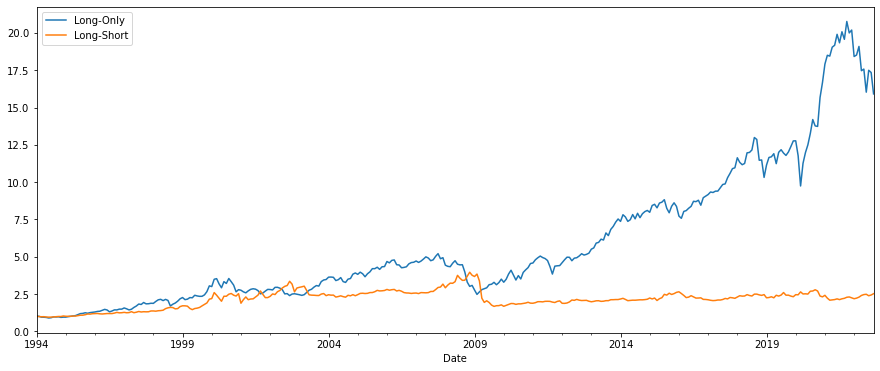

In [14]:
mom_plot = pd.DataFrame(((1/2*(size_ports['BIG HiPRIOR'] + size_ports['SMALL HiPRIOR']))-rf['RF']),columns = ['Long-Only'])
mom_plot['Long-Short'] = 0.5*((size_ports['BIG HiPRIOR'] + size_ports['SMALL HiPRIOR']) 
                              - (size_ports['BIG LoPRIOR'] + size_ports['SMALL LoPRIOR']))
(1+mom_plot['1994':]).cumprod().plot()

### 3) Is momentum just data mining, or is it a robust strategy?

#### Assess how sensitive the threshold for the “winners” and “losers” is in the results. Specifically, we compare three constructions:


- #### long the top 1 decile and short the bottom 1 deciles:

#### $$ \tilde{r}^{momD1} = r^{mom(10)} - r^{mom(1)}$$


- #### long the top 3 deciles and short the bottom 3 deciles:


#### $$ \tilde{r}^{momD3} = \frac{1}{3}(r^{mom(8)} + r^{mom(9)} + r^{mom(10)}) - \frac{1}{3} (r^{mom(3)} + r^{mom(2)} + r^{mom(1)}) $$

#### $$ \tilde{r}^{momD3} = \frac{1}{3}\sum_{k = 8}^{10} r^{mom(k)} - \frac{1}{3}\sum_{k = 1}^{3} r^{mom(k)} $$


- #### long the top 5 deciles and short the bottom 5 decile:

#### $$ \tilde{r}^{momD5} = \frac{1}{5}\sum_{k = 6}^{10} r^{mom(k)} - \frac{1}{5}\sum_{k = 1}^{5} r^{mom(k)} $$

In [15]:
mom_top1_decile = pd.DataFrame(mom_deciles['Hi PRIOR'] - mom_deciles['Lo PRIOR'],columns = ['UMD'])
mom_top3_decile = pd.DataFrame(1/3*((mom_deciles.loc[:,['PRIOR 8','PRIOR 9','Hi PRIOR']].sum(axis = 1))
                                    - (mom_deciles.loc[:,['Lo PRIOR','PRIOR 2','PRIOR 3']].sum(axis = 1))),columns = ['UMD'])

mom_top5_decile = pd.DataFrame(1/5*((mom_deciles.loc[:,['PRIOR 6','PRIOR 7','PRIOR 8','PRIOR 9','Hi PRIOR']].sum(axis = 1))
                                    - (mom_deciles.loc[:,['Lo PRIOR','PRIOR 2','PRIOR 3','PRIOR 4','PRIOR 5']].sum(axis = 1))),columns = ['UMD'])


### 2.3.a) Compare all three constructions, (in the full-sample period,) by filling out the stats in the table below for the period 1994-2022.

|<caption>Table 3: Robustness of momentum construction.</caption>|1994-2022|mean|vol|Sharpe|Skewness|corr. to $\tilde{r}^m$|corr. to $\tilde{r}^v$|
|------------------------:|-----------------------:|------------------------:|-----------------------:|------------------------:|-----------------------:|-----------------------:|-----------------------:|
|$\tilde{r}^{momD1}$|||||||||
|$\tilde{r}^{momD3}$|||||||||
|$\tilde{r}^{momD5}$|||||||||

In [16]:
samples = {'Momentum Top 1 Decile':mom_top1_decile
          ,'Momentum Top 3 Decile':mom_top3_decile
          ,'Momentum Top 5 Decile':mom_top5_decile}

mom_deciles = []
for k,v in samples.items():
    ff = ff_factors.copy()
    ff['UMD'] = v['UMD']
    mom_decile_summary = performance_summary(v['1994':])
    mom_decile_summary = mom_decile_summary.loc[:,['Mean','Volatility','Sharpe Ratio','Skewness']]
    mom_decile_summary['Corr Mkt'] = ff.loc['1994':'2022'].corr().loc['MKT',['UMD']]
    mom_decile_summary['Corr Val'] = ff.loc['1994':'2022'].corr().loc['HML',['UMD']]
    mom_decile_summary.index = [k]
    mom_deciles.append(mom_decile_summary)

mom_deciles_df = pd.concat(mom_deciles)
mom_deciles_df

,Mean,Volatility,Sharpe Ratio,Skewness,Corr Mkt,Corr Val
Momentum Top 1 Decile,0.079409,0.297952,0.266515,-1.323613,-0.335574,-0.236392
Momentum Top 3 Decile,0.034203,0.192568,0.177615,-1.355380,-0.365386,-0.229882
Momentum Top 5 Decile,0.018031,0.134026,0.134536,-1.435409,-0.357936,-0.227501


### 2.3.b) Do the tradeoffs between the 1-decile, 3-decile, and 5-decile constructions line up with the theoretical tradeoffs we discussed in the lecture?

The performance of the 1-decile construction is a stronger, but might lead to concentrated positions and thus more idiosyncratic risk. The lecture implies that the more extreme the cutoff for the "winners", the higher the mean return of the momentum portfolio. The downside is that we would expect higher volatility. This is consistent with what we see here. decile1 has the highest vol with 30.18%.

For a retail product, the top 3 decile strategy may prove to be optimum for more downside tail risk protection.

### 2.3.c) Should AQR's retail product consider using a 1-decile or 5-decile construction?

With much higher risk adjusted returns, AQR's retail product shoud consider using the 1-decile construction.

### 2.3.d) Does $\tilde{r}^{momD3}$ have similar stats to the Fama-French construction in (1). Recall that construction is also a 3-decile, long-short construction, but it is segmented for small and large stocks. Compare the middle row of Table 3 with the top row of Table 2.

Long-Short Construction with Size buckets and with 3 momentum deciles, produce pretty much similar statistics on all metrics, with the Size buckets long-short strategy performing slightly better in terms of reisk adjusted returns and correlations.

In [17]:
pd.concat([mom_rtn_long_short_summary,mom_deciles_df.loc['Momentum Top 3 Decile'].to_frame().T])

,Mean,Volatility,Sharpe Ratio,Skewness,Corr Mkt,Corr Val
Long and Short,0.047329,0.168603,0.280711,-1.433724,-0.306118,-0.238548
Momentum Top 3 Decile,0.034203,0.192568,0.177615,-1.355380,-0.365386,-0.229882


### 4. Does implementing momentum require trading lots of small stocks-- thus causing even larger trading costs?

#### For regulatory and liquidity reasons, AQR is particularly interested in using larger stocks for their momentum baskets. (Though they will launch one product that focuses on medium-sized stocks.)
#### Use the data provided on both small-stock “winners”, $r^{momSU}$, and small-stock “losers”, $r^{momSD}$, to construct a small-stock momentum portfolio,

#### $$ r^{momS}_t = r^{momSU}_t - r^{momSD}_t $$

#### Similarly, use the data provided to construct a big-stock momentum portfolio,

#### $$ r^{momB}_t = r^{momBU}_t − r^{momBD}_t $$

### 2.4.a) Fill out Table 4 over the sample 1994-2022.


|<caption>Table 4: Momentum of small and big stocks.</caption>|1994-2022|mean|vol|Sharpe|Skewness|corr. to $\tilde{r}^m$|corr. to $\tilde{r}^v$|
|------------------------:|-----------------------:|------------------------:|-----------------------:|------------------------:|-----------------------:|-----------------------:|-----------------------:|
|All stocks, $\tilde{r}^{mom:FF}_t$|||||||||
|Small stocks, $\tilde{r}^{momS}_t$|||||||||
|Large stocks, $\tilde{r}^{momB}_t$|||||||||



In [18]:
mom_small = pd.DataFrame((size_ports['SMALL HiPRIOR'] - size_ports['SMALL LoPRIOR']),columns = ['UMD'])
mom_large = pd.DataFrame((size_ports['BIG HiPRIOR'] - size_ports['BIG LoPRIOR']),columns = ['UMD'])

In [19]:
samples = {'Small Stocks':mom_small
          ,'Large Stocks':mom_large}

mom_size = []
for k,v in samples.items():
    ff = ff_factors.copy()
    ff['UMD'] = v['UMD']
    mom_size_summary = performance_summary(v['1994':])
    mom_size_summary = mom_size_summary.loc[:,['Mean','Volatility','Sharpe Ratio','Skewness']]
    mom_size_summary['Corr Mkt'] = ff.loc['1994':].corr().loc['MKT',['UMD']]
    mom_size_summary['Corr Val'] = ff.loc['1994':].corr().loc['HML',['UMD']]
    mom_size_summary.index = [k]
    mom_size.append(mom_size_summary)

mom_size.insert(0,mom_rtn_long_short_summary)
mom_size_df = pd.concat(mom_size)
mom_size_df

,Mean,Volatility,Sharpe Ratio,Skewness,Corr Mkt,Corr Val
Long and Short,0.047329,0.168603,0.280711,-1.433724,-0.306118,-0.238548
Small Stocks,0.062737,0.171615,0.365571,-1.750109,-0.306908,-0.164672
Large Stocks,0.031920,0.181863,0.175517,-0.857615,-0.277984,-0.286919


### 2.4.b) Is the attractiveness of the momentum strategy mostly driven by the small stocks? That is, does a momentum strategy in large stocks still deliver excess returns at comparable risk?

A momentum strategy in large stocks is able to deliver excess returns with similar volatility to momentum with smaller stocks, and thus still carry a risk premia. However, momentum with small stocks carries almost 2 times the premia of momentum with large stocks and thus might seem more attractive. 

According to various theories, small cap stocks carry higher risk premia due to their size and illiquidity and thus may have higher expected returns and do well for a momentum strategy. But, they do come with a lot of nuances of higher transaction costs and difficulty in trading them.

## 2.5) In conclusion, what is your assessment of the AQR retail product? Is it capturing the important features of the Fama-French construction of momentum? Would you suggest any modifications?

AQR's retail product is able to capture a risk premia similar to that created by Fama-French in their long-short momentum strategy using size buckets. However, AQR's retail product uses a long only approach which leads to a higher correlation with the Market and removes all diversification benefits of the Momentum factor.

While understanding the need of the retail product to be long only, AQR should try a different approach to reduce this correlation or launch a product as an ETF which would allow them to create the momentum product in a long-short strategy form.

## 3. Extensions

<i> This section is not graded, and you do not need to submit your answers. We may discuss some of these extensions. </i>

### 3.1 In Section 2 we analyzed whether Momentum changes substantially when we modify the construction of the factor. Let's examine that question for the Value factor.

### Re-do Tables 2, 3, and 4 but for the decile and size portfolios of the Value factor. Get this data from Ken French's website.



In [20]:
#dr.famafrench.get_available_datasets()
ff_size_value_portfolios = dr.DataReader("6_Portfolios_2x3","famafrench",start='1926-07-01')[0]/100
value_deciles = dr.DataReader("Portfolios_Formed_on_BE-ME","famafrench",start='1926-07-01')[0]/100

In [21]:
ff_size_value_portfolios.index = ff_size_value_portfolios.index.to_timestamp('M')
value_deciles.index = value_deciles.index.to_timestamp('M')

In [22]:
value_rtn_long = pd.DataFrame(((1/2*(ff_size_value_portfolios['BIG HiBM'] + ff_size_value_portfolios['SMALL HiBM']))-rf['RF']),columns = ['HML'])
ff_long = ff_factors.copy()
ff_long['HML'] = value_rtn_long['HML']
value_rtn_long_summary = performance_summary(value_rtn_long['1994':])
value_rtn_long_summary = value_rtn_long_summary.loc[:,['Mean','Volatility','Sharpe Ratio','Skewness']]
value_rtn_long_summary['Corr Mkt'] = ff_long.loc['1994':].corr().loc['MKT',['HML']]
value_rtn_long_summary['Corr Mom'] = ff_long.loc['1994':].corr().loc['UMD',['HML']]
value_rtn_long_summary.index = ['Long Only']

value_rtn_long_short = pd.DataFrame((1/2*((ff_size_value_portfolios['BIG HiBM'] + ff_size_value_portfolios['SMALL HiBM']) 
                              - (ff_size_value_portfolios['BIG LoBM'] + ff_size_value_portfolios['SMALL LoBM']))),columns = ['HML'])
ff_long_short = ff_factors.copy()
ff_long_short['HML'] = value_rtn_long_short['HML']
value_rtn_long_short_summary = performance_summary(value_rtn_long_short['1994':])
value_rtn_long_short_summary = value_rtn_long_short_summary.loc[:,['Mean','Volatility','Sharpe Ratio','Skewness']]
value_rtn_long_short_summary['Corr Mkt'] = ff_long_short.loc['1994':].corr().loc['MKT',['HML']]
value_rtn_long_short_summary['Corr Mom'] = ff_long_short.loc['1994':].corr().loc['UMD',['HML']]
value_rtn_long_short_summary.index = ['Long and Short']

In [23]:
value_top1_decile = pd.DataFrame(value_deciles['Hi 10'] - value_deciles['Lo 10'],columns = ['HML'])
value_top3_decile = pd.DataFrame(1/3*((value_deciles.loc[:,['Dec 8','Dec 9','Hi 10']].sum(axis = 1))
                                    - (value_deciles.loc[:,['Lo 10','Dec 2','Dec 3']].sum(axis = 1))),columns = ['HML'])

value_top5_decile = pd.DataFrame(1/5*((value_deciles.loc[:,['Dec 6','Dec 7','Dec 8','Dec 9','Hi 10']].sum(axis = 1))
                                    - (value_deciles.loc[:,['Lo 10','Dec 2','Dec 3','Dec 4','Dec 5']].sum(axis = 1))),columns = ['HML'])


In [24]:
samples = {'Value Top 1 Decile':value_top1_decile
          ,'Value Top 3 Decile':value_top3_decile
          ,'Value Top 5 Decile':value_top5_decile}

value_deciles = []
for k,v in samples.items():
    ff = ff_factors.copy()
    ff['HML'] = v['HML']
    value_decile_summary = performance_summary(v['1994':])
    value_decile_summary = value_decile_summary.loc[:,['Mean','Volatility','Sharpe Ratio','Skewness']]
    value_decile_summary['Corr Mkt'] = ff.loc['1994':'2022'].corr().loc['MKT',['HML']]
    value_decile_summary['Corr Mom'] = ff.loc['1994':'2022'].corr().loc['UMD',['HML']]
    value_decile_summary.index = [k]
    value_deciles.append(value_decile_summary)

value_deciles_df = pd.concat(value_deciles)

In [25]:
value_small = pd.DataFrame((ff_size_value_portfolios['SMALL HiBM'] - ff_size_value_portfolios['SMALL LoBM']),columns = ['HML'])
value_large = pd.DataFrame((ff_size_value_portfolios['BIG HiBM'] - ff_size_value_portfolios['BIG LoBM']),columns = ['HML'])

In [26]:
samples = {'Small Stocks':value_small
          ,'Large Stocks':value_large}

value_size = []
for k,v in samples.items():
    ff = ff_factors.copy()
    ff['HML'] = v['HML']
    value_size_summary = performance_summary(v['1994':])
    value_size_summary = value_size_summary.loc[:,['Mean','Volatility','Sharpe Ratio','Skewness']]
    value_size_summary['Corr Mkt'] = ff.loc['1994':].corr().loc['MKT',['HML']]
    value_size_summary['Corr Mom'] = ff.loc['1994':].corr().loc['UMD',['HML']]
    value_size_summary.index = [k]
    value_size.append(value_size_summary)

value_size.insert(0,value_rtn_long_short_summary)
value_size_df = pd.concat(value_size)

In [27]:
performance_summary(ff_factors.loc['1994':]).loc[['HML']].rename(index = {'HML':'Fama-French Value'})

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.5),CVaR (0.5),Max Drawdown,Peak,Bottom,Recovery
Fama-French Value,0.015903,0.114862,0.138449,0.207916,2.558068,-0.0452,-0.070817,-0.58428,2006-12-31,2020-09-30,NaT


### Based on these statistics,

### 3.1.a) Is the long-only version of Value substantially different?

The long-only version of Value has higher returns and volatility than the Fama-French HML. We observe very high correlations between this long-only portfolio with the excess returns of the markets, which is one of the major reasons for its high sharpe ratio.

In [28]:
pdList = [value_rtn_long_short_summary,value_rtn_long_summary]
value_comparison = pd.concat(pdList)
value_comparison

,Mean,Volatility,Sharpe Ratio,Skewness,Corr Mkt,Corr Mom
Long and Short,0.01591,0.114864,0.138509,0.207751,-0.102250,-0.238579
Long Only,0.09834,0.190476,0.516288,-0.874366,0.867919,-0.388768


### 3.1.b) Is the 1 or 5 decile version of Value substantially different?

- The 1 decile version has slightly lower returns and much higher volatility than the fama-french HML. It also has higher correlations to market compared to the negative correlations of the FF-Value portfolios.<br><br>

- The 5 decile version has much lower returns and slightly higher volatility than the fama-french HML. It also has higher correlations to market compared to the negative correlations of the FF-Value portfolios.

In [29]:
value_deciles_df

,Mean,Volatility,Sharpe Ratio,Skewness,Corr Mkt,Corr Mom
Value Top 1 Decile,0.011850,0.176888,0.066994,-0.152904,0.178362,-0.319908
Value Top 3 Decile,0.005763,0.116075,0.049653,-0.289519,0.174831,-0.322464
Value Top 5 Decile,0.000176,0.082218,0.002141,-0.039878,0.158168,-0.301238


### 3.1.c) Does the 3 decile version of Value look like the Fama-French version?

The 3 decile version has much lower returns and similar volatility compared to the fama-french HML. It also has higher correlation to the market returns.

### 3.1.d) Do the Big Value and Small Value factors look similar?

In [30]:
value_size_df

,Mean,Volatility,Sharpe Ratio,Skewness,Corr Mkt,Corr Mom
Long and Short,0.015910,0.114864,0.138509,0.207751,-0.102250,-0.238579
Small Stocks,0.036722,0.129920,0.282651,0.271015,-0.269082,-0.102366
Large Stocks,-0.004903,0.126153,-0.038862,0.015334,0.090916,-0.329036
